# Exploratory Analysis


This notebook is the starting point of a data science project about image recognition. I am going to perform an exploratory analysis (**EDA**) on **Google Landmark Recognition 2020** dataset. My main objective is giving as detailed explanations as possible about the characteristics of the data. So that the conclusions extracted from this notebook can help others and also me for further researches and the implementation of instance-level recognition system.

# Index of contents
1. **Importing libraries**
2. **Loading the dataset**
3. **Data Visualization**
4. **Image Visualization**
5. **Conclusions**
6. **References**

# Importing libraries
The modules I am using are the most basic and common ones for this kind of work. Just trying to make things simple. 

In [1]:
import os
import pandas as pd
import numpy as np
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

#Seed for making reproducible experiments
seed = 256

# Loading data
The `csv` file of the training set would be enough for now.

In [2]:
train_data = pd.read_csv("../input/landmark-recognition-2020/train.csv")
train_data.sample(5, random_state=seed) #Checking if it is loaded correctly

,id,landmark_id
228326,72e575187a9be866,29341
1025947,30bbb73fc6c0872b,132591
662808,bf59585b812e8280,85019
197682,47a093540ab0a39b,25602
501996,e966c3fba528c577,64086


The file contains two columns, the **id** of the image that comes from the folders names as it is explained on the competition basis and the **landmark_id** which is the unique label of each image.

In [3]:
print("Training data size", train_data.shape)

Training data size (1580470, 2)


There are over one million and half images what is a very huge amount of data to deal with. 

In [4]:
print("Number of unique labels", train_data["landmark_id"].nunique())

Number of unique labels 81313


There are nearly one hundred thousand different types of landmarks what is very far from "classical" multi-class problems in which the range of classes is not so extensive. 

# Data visualizations
Once the data is loaded, let's see the data with different graphic visualizations to understand it and also think about how can be processed later on.

## Number of images per labels

In [5]:
# Calculating the n_images per landmark
temp =train_data.groupby(["landmark_id"]).size().reset_index(name='n_images')
temp = temp.sort_values(by='n_images', ascending=False)
temp.sample(5,random_state=seed)

,landmark_id,n_images
55816,139002,37
10981,27199,5
2985,7424,12
43044,107040,8
72227,180507,5


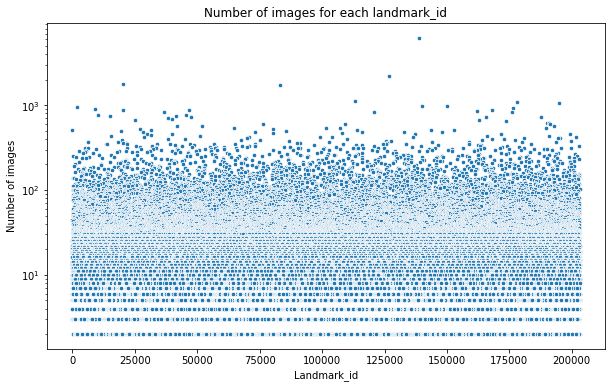

In [6]:
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x='landmark_id', y='n_images', data=temp, s=20)
scatter.set(yscale="log")
plt.ylabel("Number of images")
plt.xlabel("Landmark_id")
plt.title("Number of images for each landmark_id")
plt.show()

It seems that the most part of the classes has under one hundred images. The tangle of points is concentrated on the middle range, between 50 and 100 images. Below this range, apparently there are some kind of stairs steps where the minoritary classes are represented. Also above the commented range there are some distinguished points which corresponds to the most frequent landmarks of the database.

## Most frequent landmarks (Top 10)

Bar plot of the most common landmarks of the dataset

In [7]:
temp.head(10).style.background_gradient(subset='n_images') 

,landmark_id,n_images
55807,138982,6272
50843,126637,2231
8211,20409,1758
33462,83144,1741
45494,113209,1135
71194,177870,1088
77976,194914,1073
60095,149980,971
56171,139894,966
750,1924,944


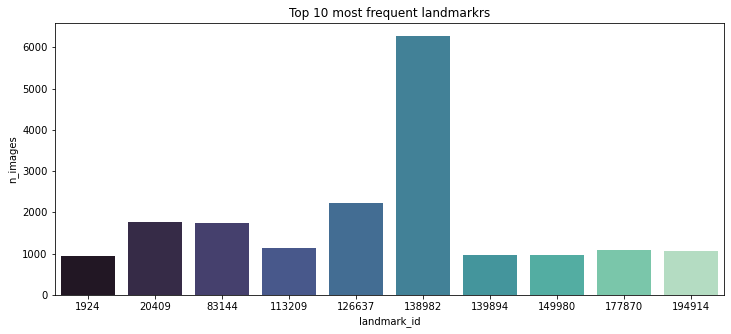

In [8]:
plt.figure(figsize = (12,5))
plt.title("Top 10 most frequent landmarkrs")
sns.barplot(x='landmark_id', y='n_images', data=temp.head(10), palette="mako")
plt.show()

There is one landmark that clearly stand out from the rest with a very notable difference on the number of instances. Also it can be said that most of the top-10 landmark has an average of one thousand ocurrences each one.  

## Least frequent landmarks (Bottom 10)
Bar plot of the least common landmarks of the dataset

In [9]:
# Calculating the bottom 10 landmarks
temp.tail(10).style.background_gradient(subset='n_images') 

,landmark_id,n_images
34141,84791,2
34124,84731,2
53666,133657,2
34117,84711,2
34112,84686,2
34109,84677,2
14991,36989,2
53680,133688,2
6966,17316,2
44791,111405,2


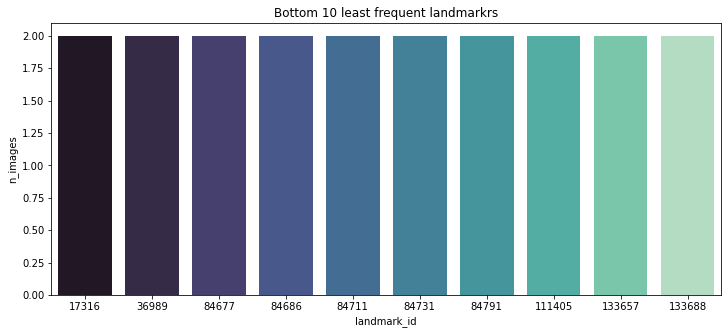

In [10]:
plt.figure(figsize = (12,5))
plt.title("Bottom 10 least frequent landmarkrs")
sns.barplot(x='landmark_id', y='n_images', data=temp.tail(10), palette='mako')
plt.show()

It is easy to think about the enormous difference on instances in respect of the previous ones. This fact could lead us to decision as data augmentation or cleaning the least frequent ones from the data set.

## Landmark distribution

With the previous plots it is clear that there is a high imbalance on the distribution of labels. For that reason, let's see by parts how they are distributed.

In [11]:
temp.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.99])

,landmark_id,n_images
count,81313.000000,81313.000000
mean,101291.902070,19.436867
std,58740.916419,42.877489
min,1.000000,2.000000
25%,50237.000000,5.000000
50%,101073.000000,9.000000
75%,152146.000000,20.000000
80%,162473.600000,24.000000
90%,182907.600000,42.000000
99%,201117.520000,156.000000


The `99%` of the labels have under 156 images what is far away from the most frequent ones as we have seen before.

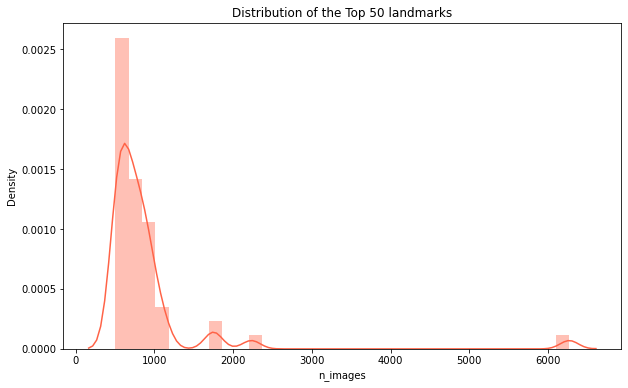

In [12]:
plt.figure(figsize = (10,6))
plt.title("Distribution of the Top 50 landmarks")
plt.ylabel('Density')
sns.distplot(temp['n_images'][:50], color='tomato')
plt.show()

Now, it is more evident than the most frequent labels oscilates among five hundred and one thousand images with the clear outlier landmark commented previously.

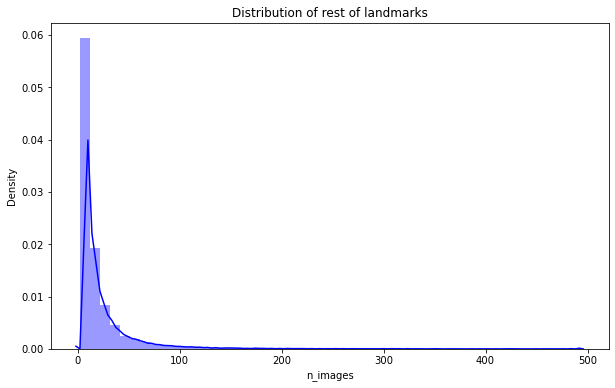

In [13]:
plt.figure(figsize = (10,6))
plt.title("Distribution of rest of landmarks")
plt.ylabel('Density')
sns.distplot(temp['n_images'][51:], color='blue')
plt.show()

The rest of the landmarks has less than one hundred images each one.

## Number of landmarks within an number image range

Once seen the imbalance distribution, we can group landmarks based on their number of images. With that we can infer how to make partitions of the database.

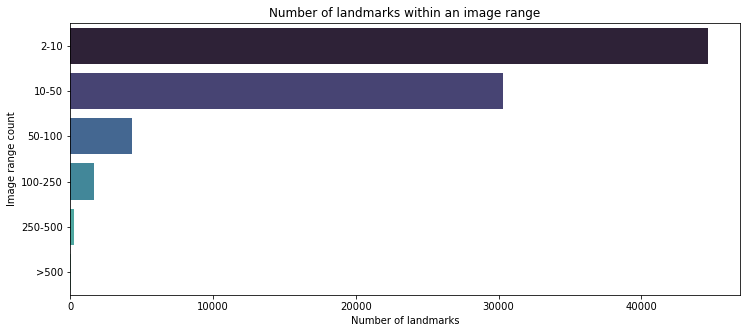

In [14]:
range_labels = ['2-10', '10-50', '50-100', '100-250', '250-500', '>500']
range_counts = [temp[temp['n_images'] <= 10]['landmark_id'].count(), temp[(temp['n_images'] > 10) & (temp['n_images'] <= 50)]['landmark_id'].count(),
                temp[(temp['n_images'] > 50) & (temp['n_images'] <= 100)]['landmark_id'].count(),temp[(temp['n_images'] > 100) & (temp['n_images'] <= 250)]['landmark_id'].count(),
                temp[(temp['n_images'] > 250) & (temp['n_images'] <= 500)]['landmark_id'].count(),temp[temp['n_images'] > 500]['landmark_id'].count() ]

plt.figure(figsize=(12,5))
plt.title("Number of landmarks within an image range")
plt.ylabel("Image range count")
plt.xlabel("Number of landmarks")
sns.barplot(range_counts, range_labels, palette='mako')
plt.show()

On the bar plot above we can see that almost all landmarks has under 50 images what is seen at first sight at the beggining. Just few points had above five hundred images.

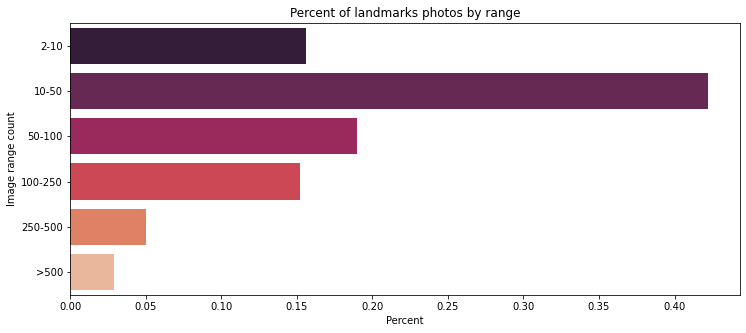

In [15]:
total = temp['n_images'].sum()
range_percents = [temp[temp['n_images'] <= 10]['n_images'].sum()/total, temp[(temp['n_images'] > 10) & (temp['n_images'] <= 50)]['n_images'].sum()/total,
                temp[(temp['n_images'] > 50) & (temp['n_images'] <= 100)]['n_images'].sum()/total,temp[(temp['n_images'] > 100) & (temp['n_images'] <= 250)]['n_images'].sum()/total,
                temp[(temp['n_images'] > 250) & (temp['n_images'] <= 500)]['n_images'].sum()/total,temp[temp['n_images'] > 500]['n_images'].sum()/total ]

plt.figure(figsize=(12,5))
plt.title("Percent of landmarks photos by range")
plt.ylabel("Image range count")
plt.xlabel("Percent")
sns.barplot(range_percents, range_labels, palette='rocket')
plt.show()

This bar plot is just a confirmation of the percentiles described before. At first sight, it is noticeable that `90%` of the data has less than one hundred photos. Moreover, the range from **10-50 photos per landmark** is the predominant in the database being nearly the half of it. Also, we must be careful because there is a high percent of landmark images on the ones that have just a couple of photos per class. 

# Image visualization

Now it is turn to see some random images from the dataset. So let's start by loading the corresponding paths.

In [16]:
TRAIN_DIR= "../input/landmark-recognition-2020/train"

## Some Landmark photos

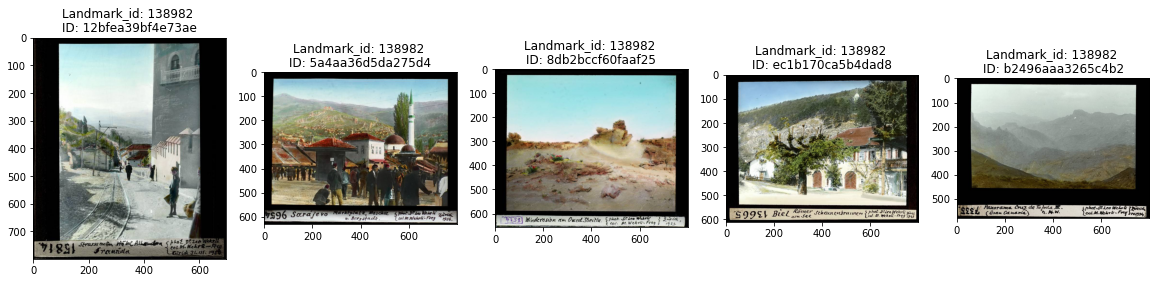

In [17]:
def display_images(images):
    f = plt.figure(figsize=(20,20))
    
    for i, id in enumerate(images):
        image_path = os.path.join(TRAIN_DIR, f'{id[0][0]}/{id[0][1]}/{id[0][2]}/{id[0]}.jpg')
        image = mpimg.imread(image_path)
        f.add_subplot(1,5,i+1)
        plt.imshow(image)
        plt.title(f'Landmark_id: {id[1]} \nID: {id[0]}')
    
    plt.show()

landmark_id = temp.head(1)['landmark_id'].values[0]
top = train_data[train_data['landmark_id'] == landmark_id].sample(5,random_state=seed).values  #the seed affects to the plotted images!!
display_images(top)

It is very interesting the fact that the images of the most common landmark are so diferrent one from other. In the sample, there are no common elements in none of the photos, maybe just the dessert, but that is all and it is barely distinguihed in two of them. This fact shows us the intra-class imbalance as other challenging characteristic of this dataset.

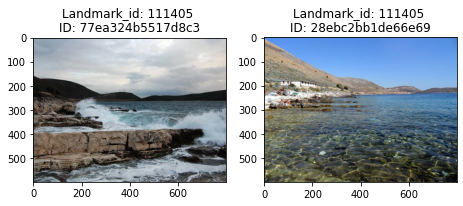

In [18]:
landmark_id = temp.tail(1)['landmark_id'].values[0]
bottom = train_data[train_data['landmark_id'] == landmark_id].sample(2,random_state=seed).values
display_images(bottom)

This is one of the least common landmarks along the dataset. In contrast of the previous one, here it is more likely to identify by first sight that there are photos of the same beach. However, it is not so easy because the persepctive, light and place which were taken are very different.

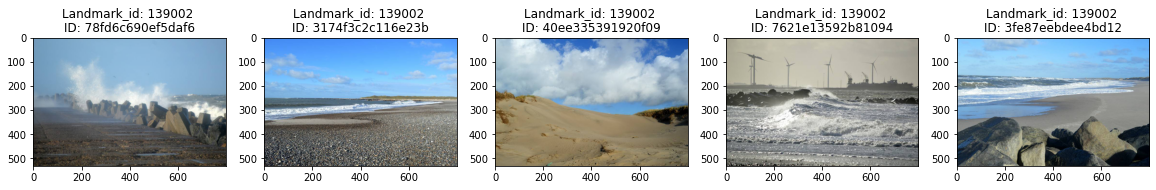

In [19]:
landmark_id = temp.sample(1,random_state=seed)['landmark_id'].values[0]
random = train_data[train_data['landmark_id'] == landmark_id].sample(5,random_state=seed).values
display_images(random)

Finally, the display of one random landmark. In this case a church, identifying the common points is more clear, but again the perspectives are several as well as the light conditions. Also, one of the photos is some kind of painting that is supposed to belong to the inside part of the church. Meanwhile there is another photo that is taken from the sky and it is very difficult to recognize where is the church on it. These are the aspects with which the models will struggle on their learning. Another thing that I have forgotten to mention before is the variance on the image sizes. So, let's see some statistics about the photos characteristics.

## Photo characteristics

As there are one million and half photos, it is not very efficient to analyze all of them, so I am going to use just a significant bunch of them.

## Image sizes

In [20]:
def image_data(images):
    widths = []
    heights = []
    pixels = []
    for i, id in enumerate(images):
        image_path = os.path.join(TRAIN_DIR, f'{id[0]}/{id[1]}/{id[2]}/{id}.jpg')
        img = cv2.imread(image_path)
        h, w = img.shape[0], img.shape[1]  #Don't need the color channel now
        p = img.size
        widths.append(w)
        heights.append(h)
        pixels.append(p)
        
    data = {"height": heights, "width": widths,"pixels": pixels }
    return pd.DataFrame(data)


bunch_photos = train_data.sample(10000, random_state=seed)

photo_data = image_data(bunch_photos["id"].values)
photo_data.shape

(10000, 3)

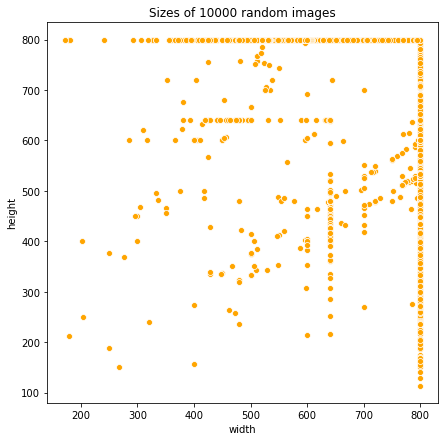

In [21]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='width', y='height', data=photo_data, color='orange')
plt.title("Sizes of 10000 random images")
plt.show()

There are a big variaty of image sizes, but it seems that the predominant height and width are 800 pixels. This is something important to consider for the pre-processing of the image data.

## Image aspect ratios

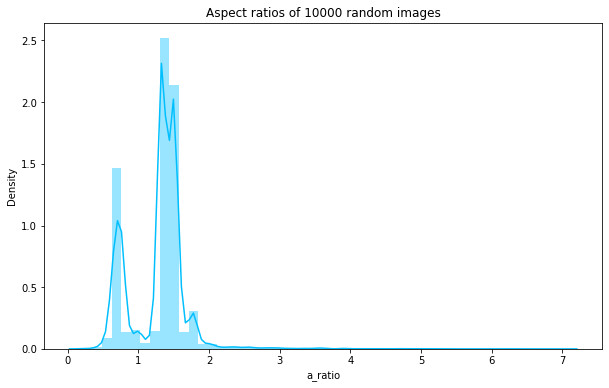

In [22]:
photo_data['a_ratio'] = photo_data['width'] / photo_data['height']

plt.figure(figsize=(10,6))
sns.distplot(photo_data['a_ratio'], color='deepskyblue')
plt.title("Aspect ratios of 10000 random images")
plt.ylabel("Density")
plt.show()

Linked to the width and height of the photos we have the aspect ratio. In this sample the most common one is between one and two what means portrait photos. However, there is an important percentege which are vertical due to their ratio is under one (width smaller than height) 

## Total pixel per image

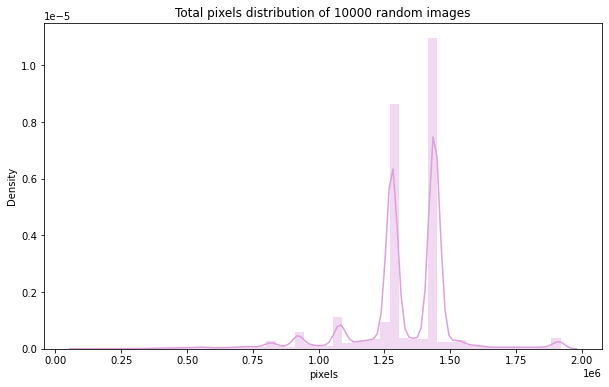

In [23]:
plt.figure(figsize=(10,6))
sns.distplot(photo_data['pixels'], color='plum')
plt.title("Total pixels distribution of 10000 random images")
plt.ylabel("Density")
plt.show()

The samples of photos oscilates between one and one and half megapixels, so they are not so heavy sizes as the ones we are commonly doing on our daily life.

# Conclusions
In conclusion there are some facts that we must pay special attention in the creation of a model:
* Huge unbalanced distribution of labels
* High variance inside classes
* Very different image sizes
* Perspective, light conditions, common points and other image features

# References
* [Visualizing Landmarks (+more EDA)](https://www.kaggle.com/jeffreybraun/visualizing-landmarks-more-eda)
* [[EDA] : Google Landmark Recognition 2020](https://www.kaggle.com/namanj27/eda-google-landmark-recognition-2020)